# Exploration of Insight fellows' projects and companies they joined
Here, I am interested in the types of projects that fellows in the Insight program worked on and the types of companies they later joined

I focus on NLP and topic modeling (using NMF) to gain some snapshot insights. Specifically:
1. What kinds of topics can the different projects be classified into?
2. How may companies be split into subcategories?
3. Can we see a relationship between the type of projects that each fellow completed and the company that they later joined?

## Some caveats/notes
- The data here is based on fellows' information scrapped from the Insight data science program website
- It is important to note that the information about projects and companies are very limited (e.g. only title information can be retrieved for projects and the only information we get for companies are their name).
- I've chosen a very quick and dirty way of creating features from the company name (i.e. via wikipedia summary) because my current requirements are for this to be fast, free and easy (e.g. no registration, payment or api key, etc). There are many better ways to get information about companies that are complete and well-structured but they don't meet the requirements above.

In [1]:
#basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#webscrapping-related packages
from bs4 import BeautifulSoup
import urllib
import requests
import wikipedia

#nlp-related packages
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from nltk.corpus import stopwords

# ML-related packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics

#Other packages
import time

In [2]:
# # reduce df truncation for easier inspection (temporarily disabled for github display purpose)
# pd.set_option('max_colwidth', 100, 'max_rows', 1000)

# 1. Webscrapping fellows' information

In [3]:
url = 'https://www.insightdatascience.com/fellows?61ea5d1b_page='
pages = list(range(1,8)) #checked the website manually and 8 is the last page with fellows info

# Check out what the html code looks like
page = 1
temp_url = url + str(page)
r = requests.get(temp_url)
html_doc = r.text
soup = BeautifulSoup(html_doc, "lxml")
# print(soup.prettify())

### A quick search within the above prettified output tells me the html classes I should use below to retrieve information about each fellow. While I am mostly interested about their projects and companies, I'm going to download all available information (name, project, background, company, title) for each fellow in case I want to look at them later.

In [4]:
# After exploring prettified html above and noting the classes of interest, extract data from each page

data = []
for page in pages:
    temp_url = url + str(page)
    r = requests.get(temp_url)
    html_doc = r.text
    soup = BeautifulSoup(html_doc, "lxml")
    
    #get info frame each page
    name = soup.findAll('div', attrs={'class':'tooltip_name'})
    proj = soup.findAll('div', attrs={'class':'tooltip_project'})
    backgrd = soup.findAll('div', attrs={'class':'tooltip_background'})
    company = soup.findAll('div', attrs={'class':'fellow_company'})
    title = soup.findAll('div', attrs={'class':'toottip_title'})
    
    # Append only the text info of each fellow as a row
    for i in range(len(name)):
        data.append((name[i].text, proj[i].text,backgrd[i].text, company[i].text, title[i].text))

# Store final output as a df and then save as a csv file
df = pd.DataFrame(data, columns=['Name', 'Project', 'Background', 'Company','Title'])
# df.to_csv('data.csv')
df

,Name,Project,Background,Company,Title
0,JP Bida,Measuring the Impact of Open Source Coders on ...,"Bio-X Games, Stanford, Postdoc",Capital One,Director of Risk
1,Douglas Mason,Email Searcher: Search & Visualize Your Mailbox,"Physics, Harvard University,Â PhD\n",Twitter,Data Scientist
2,Virot Ta Chiraphadhanakul,Tweet Timeline: Visualizing the Impact of Soci...,"Operations Research, MIT, PhD",Facebook,Data Scientist
3,Julia Viladomat,Sentiment Analysis Based on Social Media,"Statistics, Stanford, Postdoc",Adobe,Data Scientist
4,David Freeman,Flight Delay Predictor,"Mathematics, Stanford, Postdoc",LinkedIn,Head of Anti-Abuse Engineering
5,Jessica ZÃºÃ±iga,Email Contacts Automatically Grouped & Ranked,"Mathematics, Duke, Postdoc",LinkedIn,Senior Data Scientist
6,Harold Nguyen,Analysis of New York Stop-and-Frisk Data,"Physics, UC Riverside, PhD",Proofpoint,Data Scientist
7,Sebastien de Larquier,CouchTube: YouTube TV shows in one click,"Space Physics, Virgina Tech, PhD",Netflix,Data Scientist
8,Paula Therese Lang,SchoolGeo: Empowering Parents to Make Informed...,"Computational Biology, UC Berkeley, Postdoc",CreativeLIVE,Senior Data Scientist
9,Nan Ma,Event Map: Get Local News from Twitter,"Electrical Engineering & Computer Science, UC ...",Microsoft Yammer,Data Engineer


# 2. Visual inspection and feature engineering
Looking at the downloaded dataset above (i.e. df) and focusing on the two columns of interest (i.e. Project and Company), it is clear that some cleaning should be done:
1. There are many Â symbols in the Project column (ditto for df.Background, but I'm going to ignore this column here)
2. CamelCase is often used to name projects (e.g. CouchTube, SchoolGeo, HipHopper)
3. There are a lot of similar variation of the same words for projects (e.g. Find vs finding) so stemming would be a good idea
4. Since the only information provided for companies are their names, features will have to be created for them (more information later).

In [5]:
df = pd.read_csv('data.csv',index_col=0)

In [6]:
# Check and drop duplicate rows in df
org_size = df.shape[0]
df.drop_duplicates(subset=None, keep='first', inplace=True)
print('{0} out of {1} rows were duplicates and thus deleted'.format((org_size - df.shape[0]), org_size))

0 out of 700 rows were duplicates and thus deleted


## 2.1. Focusing on "Projects" -- cleaning and topic modeling

In [7]:
## Clean df.Project
    #split on camelcase, tokenize and get rid of â symbol

stemmer = SnowballStemmer('english')
    
def rstop_token(text):
    temp1 = [re.sub('(?!^)([A-Z][a-z]+)', r' \1', w).split() for w in word_tokenize(text) if (w.isalpha() and 'â' not in w.lower())]
    temp2 = [word.lower() for l in temp1 for word in l]
    temp3 = [t for t in temp2 if t not in stopwords.words('english')]
    temp = [' '.join([stemmer.stem(word) for word in text.split(' ')]) for text in temp3]
    return temp

# Apply rstop_token to Project
df.Project = df.Project.apply(rstop_token)
df.Project = df.Project.apply(lambda w: ' '.join(w))


NMF using n_comps = 2
Topic 1: match,game,video,recommend,local,new,place,help,best,find
Topic 2: ad,new,success,perform,forecast,rate,use,user,data,predict
Reconstruction error = 55.00678944095531

NMF using n_comps = 3
Topic 1: perfect,video,match,safe,local,new,help,place,best,find
Topic 2: campaign,new,success,perform,forecast,rate,use,user,data,predict
Topic 3: click,ad,bubbl,alreadi,video,like,indi,game,news,recommend
Reconstruction error = 54.522573904832534

NMF using n_comps = 4
Topic 1: perfect,video,match,safe,local,new,help,place,best,find
Topic 2: campaign,new,success,perform,forecast,rate,use,user,data,predict
Topic 3: base,engin,love,movi,alreadi,video,like,indi,game,recommend
Topic 4: daili,topic,websit,time,tweet,hacker,feed,engag,bubbl,news
Reconstruction error = 54.08846878184815

NMF using n_comps = 5
Topic 1: next,park,perfect,video,match,safe,new,place,best,find
Topic 2: campaign,new,success,forecast,perform,rate,user,use,data,predict
Topic 3: base,engin,love,mov

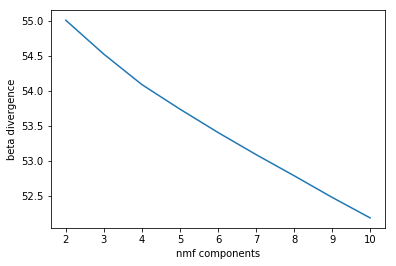

In [8]:
# def function to make BoW and perform NMF using an array of component sizes
    # for each n_comp, store top 10 words for each topic and the W and H matrices

n_comp_range = list(range(2,11)) # number of topics range from 2 to 10

def make_bow_nmf_range(df, n_comp_range):
    
    beta_divergence = []
    
    #make Bag of words
    count = CountVectorizer(min_df=2) #min_df=2, ngram_range=(1,2),stop_words="english"
    bag_of_words = count.fit_transform(df)

    BoW_feature_names = np.array(count.get_feature_names())
    Proj_BoW = bag_of_words.toarray()

    for n_comps in n_comp_range:
        print()
        print('NMF using n_comps = {}'.format(n_comps))

        # NMF
        nmf = NMF(n_components=n_comps, solver="mu")
        W = nmf.fit_transform(Proj_BoW) #weights
        H = nmf.components_ #components
        for i, topic in enumerate(H):
        #     print  (i, topic)
            print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in BoW_feature_names[topic.argsort()[-10:]]])))
        
        #reconstruction error
        beta_div = nmf.reconstruction_err_
        beta_divergence.append(beta_div)
        print('Reconstruction error = {}'.format(beta_div))
        
    plt.plot(n_comp_range,beta_divergence)
    plt.xlabel('nmf components')
    plt.ylabel('beta divergence')
    plt.show()
        
make_bow_nmf_range(df.Project, n_comp_range)

### 2.1.1 Interim summary for projects (based on NMF output above):
As expected, the reconstruction error (a.k.a beta divergence) decreases as the number of components increase. However, the differences are not substantial.

Ignoring beta divergence and focusing on the top words associated with each topic, we can observe some interesting results:
- Specifically, when n_comps = 3, we can see that "find", "predict" and "recommend" show up as top words in separate topics. Further, "find" is related to "local" and "place", "predict" is related to "forecast", and "recommend" is related to "movie", "video", "love" and "like". These words make sense together.
- Increasing n_comps to 4 or 5 also gives us relatively independent topics that seem to make sense: (a) "topics" and "news" and (b) "stack", "overflow" and "help"
- Increasing the number of topics even further (e.g. n_comps = 10) tend to give us overlapping top words (e.g. "place" appears in the top words for topics 1, 6 and 10 when n_comps =10). It appears that the differences between these three topics are now in the way "place" is related to other content (i.e. places to walk your dog, versus places related to favourite restaurants, versus places to avoid that is related to crime in order to stay safe)

## 2.2. Focusing on "Company" -- feature engineering, cleaning and topic modeling

### 2.2.1 Retrieving  information from wikipedia to create features based on "Company"
As mentioned before, to create features from the company name, I'm choosing a fast, free and easy method. There are many better ways to get information about companies that are more complete and better structured but they don't meet the requirements above (e.g. they frequently require registration, payment or an api key, etc) so for the time being I'm making do with this.

Specifically:
- I'm creating features by extracting the wikipedia summary related to each company name (See first cell below for an example using "Facebook"). To improve the likelihood of the top search result being a company name, I am adding "company" after the company name to perform the search.
- Based on my prior testing of wikipedia search results using some companies, the first sentence of the summary is usually the most precise in terms of defining the company. Thus, I'm just using that one sentence to create features
- Some smaller companies do not have search results in wikipedia, so I'm just going to ignore them.

In [9]:
# Example of first sentence in summary when performing a wikipedia search on "facebook"
search = wikipedia.search('Facebook'  + ' company', results = 1)
page =  wikipedia.page(search)
description = sent_tokenize(page.summary)[0]
print('Example of first sentence in wikipedia summary when searching for "Facebook":')
print()
print(description)

Example of first sentence in wikipedia summary when searching for "Facebook":

Facebook, Inc. is an American online social media and social networking service company.


#### The next cell below took around 5mins to complete for me on my macbook pro (Please uncomment it to run). 
  For the current purpose of showcasing my work, the df_company.csv file has already been stored and is loaded below after the commented wikipedia search cell.

        #MY PRINTOUT
        # Found info for 338 companies out of 363 companies in list
        # Time taken = 313.64seconds

In [10]:
# company_list = df.Company.unique()
# len(company_list)

# company_info = []
# company_wo_info = 0
# t = time.time()
# for i_company in company_list:
# #     print(i_company)
# #     temp_info = []
#     try:
#         search = wikipedia.search(i_company  + ' company', results = 1)
#         page =  wikipedia.page(search)
#         description = sent_tokenize(page.summary)[0]
#         company_info.append(description)
#     except:
#         company_wo_info += 1
#         company_info.append('nan')
# #         print(': Not in Wikipedia!')
# elapsed = time.time() - t
# print('Found info for {0} companies out of {1} companies in list'.format(len(company_info)-company_wo_info,len(company_info)))
# print('Time taken = {}seconds'.format(round(elapsed,2)))

# df_company = pd.DataFrame(zip(company_list, company_info), columns=['Company','company_info'])
# df_company.to_csv('df_company.txt', sep='\t')

In [11]:
df_company = pd.read_csv('df_company.txt',index_col=0,sep='\t')
df_company.dropna(inplace = True)
df_company

,Company,company_info
0,Capital One,Capital One Financial Corporation is a bank ho...
1,Twitter,Twitter () is an American online news and soci...
2,Facebook,"Facebook, Inc. is an American online social me..."
3,Adobe,Adobe Inc. ( ə-DOH-bee) is an American multina...
4,LinkedIn,LinkedIn () is a business and employment-orien...
5,Proofpoint,Proofpoint is an enterprise security company b...
6,Netflix,"Netflix, Inc. is an American media-services pr..."
7,CreativeLIVE,CreativeLive is an online education platform t...
8,Microsoft Yammer,Yammer (/ˈjæm.ər/ ) is a freemium enterprise s...
9,YouTube,YouTube is an American video-sharing website h...


### 2.2.2 Clean "company_info" and explore using topic modeling

As observed above, the wikipedia description results (stored in "company_info" column) require some cleaning
- Remove pronounciation-related words
- Remove stopwords and non-English words (e.g. /ˈjæm.ər/ )
- There are a couple of weird results (e.g. index 10 -- PlotWatt). Since my feature engineering goal is for this to be quick, simple and easy, and since the results are okay for most of the companies, I'm just going to ignore them.

In [12]:
# Clean company_info
def clean_comp_info(company_info):
    temp_company_info = [w for w in word_tokenize(company_info.lower())]
    temp_clean_info = [w for w in temp_company_info if (w not in stopwords.words('english') and bool(re.search('^[a-z\-]+$', w))==True)]
    clean_info = ' '.join(temp_clean_info)
    return clean_info

df_company.company_info = df_company.company_info.apply(clean_comp_info)

In [13]:
df_company

,Company,company_info
0,Capital One,capital one financial corporation bank holding...
1,Twitter,twitter american online news social networking...
2,Facebook,facebook american online social media social n...
3,Adobe,adobe american multinational computer software...
4,LinkedIn,linkedin business employment-oriented service ...
5,Proofpoint,proofpoint enterprise security company based s...
6,Netflix,netflix american media-services provider headq...
7,CreativeLIVE,creativelive online education platform broadca...
8,Microsoft Yammer,yammer freemium enterprise social networking s...
9,YouTube,youtube american video-sharing website headqua...



NMF using n_comps = 2
Topic 1: software,founded,known,technology,multinational,headquartered,california,based,american,company
Topic 2: metropolitan,university,united,states,based,media,cancer,city,york,new
Reconstruction error = 58.25368647290639

NMF using n_comps = 3
Topic 1: headquartered,east,technology,software,india,founded,known,based,american,company
Topic 2: headquartered,university,united,states,based,media,cancer,city,york,new
Topic 3: to,san,technology,consumer,based,multinational,headquartered,corporation,california,american
Reconstruction error = 57.3550217542108

NMF using n_comps = 4
Topic 1: technology,headquartered,multinational,east,india,founded,known,based,american,company
Topic 2: area,metropolitan,based,headquartered,media,university,cancer,city,york,new
Topic 3: to,san,technology,consumer,based,multinational,corporation,headquartered,california,american
Topic 4: financial,software,companies,service,based,states,big,united,analytics,data
Reconstruction error = 

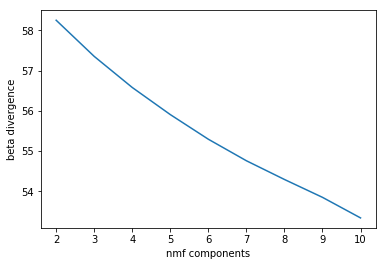

In [14]:
## Using the earlier function I created in section 2.1, convert company_info into BoW and perform NMF
n_comp_range = list(range(2,11)) # number of topics range from 2 to 10
make_bow_nmf_range(df_company.company_info, n_comp_range)

### 2.2.3 Interim summary for Company (based on NMF output above):
Again, as expected, the reconstruction error (a.k.a beta divergence) decreases as the number of components increase. However, as before with Projects, the differences are not substantial.

Ignoring beta divergence and focusing on the top words associated with each topic, we can see that they are not as coherent as what we saw before with Projects
- There are many overlapping top words between topics even when n_comps is low (e.g. headquartered)
- There are a lot of top words associated with locations (e.g. california, american, san, francisco) that may not fit our purpose here since they likely are not related to project names later.

Nevertheless, we can still observe some latent topics among the noise. Examples, of word groups that make sense:
- "research", "university", "cancer"
- "insurance", "financial"
- " big", "analytics", 'data'

    --> Note that I did not use n_grams earlier when making the bag of words for topic modeling, so these coherent groupings are a result of NMF

## 2.3 Looking at "Projects" and "Company" -- is there a relationship between them?

In [15]:
merged_df = df.merge(df_company, 'left', on = 'Company')
merged_df.dropna(inplace = True)
merged_df.drop(merged_df[merged_df.Project==''].index,inplace=True) #delete rows where Proj column is empty after cleaning
print(merged_df.info())
merged_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 657 entries, 0 to 699
Data columns (total 6 columns):
Name            657 non-null object
Project         657 non-null object
Background      657 non-null object
Company         657 non-null object
Title           657 non-null object
company_info    657 non-null object
dtypes: object(6)
memory usage: 35.9+ KB
None


,Name,Project,Background,Company,Title,company_info
0,JP Bida,measur impact open sourc coder github,"Bio-X Games, Stanford, Postdoc",Capital One,Director of Risk,capital one financial corporation bank holding...
1,Douglas Mason,email searcher search visual mailbox,"Physics, Harvard University,Â PhD\n",Twitter,Data Scientist,twitter american online news social networking...
2,Virot Ta Chiraphadhanakul,tweet timelin visual impact social media,"Operations Research, MIT, PhD",Facebook,Data Scientist,facebook american online social media social n...
3,Julia Viladomat,sentiment analysi base social media,"Statistics, Stanford, Postdoc",Adobe,Data Scientist,adobe american multinational computer software...
4,David Freeman,flight delay predictor,"Mathematics, Stanford, Postdoc",LinkedIn,Head of Anti-Abuse Engineering,linkedin business employment-oriented service ...
5,Jessica ZÃºÃ±iga,email contact automat group rank,"Mathematics, Duke, Postdoc",LinkedIn,Senior Data Scientist,linkedin business employment-oriented service ...
6,Harold Nguyen,analysi new york data,"Physics, UC Riverside, PhD",Proofpoint,Data Scientist,proofpoint enterprise security company based s...
7,Sebastien de Larquier,couch tube tube tv show one click,"Space Physics, Virgina Tech, PhD",Netflix,Data Scientist,netflix american media-services provider headq...
8,Paula Therese Lang,school geo empow parent make inform decis,"Computational Biology, UC Berkeley, Postdoc",CreativeLIVE,Senior Data Scientist,creativelive online education platform broadca...
9,Nan Ma,event map get local news twitter,"Electrical Engineering & Computer Science, UC ...",Microsoft Yammer,Data Engineer,yammer freemium enterprise social networking s...


### 2.3.1. General observations comparing "Projects" and "Company"

In the df above, we can now see Project and company_info after feature engineering and cleaning

Heuristically eyeballing the df above doesn't really tell us much, but based on the topic modeling performed earlier, there are some expectations that might be constructed based on what might be found IF (!!!) Project and Company are related. For example:
- We might expect fellows who joined the same companies to have projects that sound similar
- We might expect companies with similar information to be related to fellows with similar Projects

Even though NMF is based on linear algebra between the components of latent topics and how the different samples might be related to the components that make up the topics, I'm going to use a shortcut method here to try to categorize each fellow into different topics ---> Specifically, I'm going to classify each Project and Company based on the most dominant topic (i.e. the topic with the maximum weight in the W matrix produced by NMF).

The function "dom_topic_ncomp" in the cell below will create a matrix output (sample x the number of components that I am performing NMF on) that stores the dominant theme for each sample (row) for each nmf_comp (column)

I will also use the same n_comps that I explored earlier separately for Projects and Companies (i.e. n_comps from 2 to 10)

In [16]:
## function for using NMF to creating dominant topics/themes (via max weight) for each sample across different n_comp

n_comp_range = list(range(2,11)) # number of topics range from 2 to 10

def dom_topic_ncomp(df, n_comp_range):

    #make Bag of words
    count = CountVectorizer(min_df=2)
    bag_of_words = count.fit_transform(df)

    BoW_feature_names = np.array(count.get_feature_names())
    Proj_BoW = bag_of_words.toarray()

    dom_topics = []
    
    for n_comps in n_comp_range:

        # NMF
        nmf = NMF(n_components=n_comps, solver="mu")
        W = nmf.fit_transform(Proj_BoW) #weights
        H = nmf.components_ #components
        
        # get dominant topics for each sample for current n_comps
        norm_features = normalize(W)
        temp_dom_topics = np.argmax(norm_features,axis=1)
        dom_topics.append(temp_dom_topics)

    dom_topics_df = pd.DataFrame(dom_topics, index = ['n_comp'+ '{}'.format(i) for i in n_comp_range]).transpose()
    
    return dom_topics_df

In [17]:
# Get dominant/themes for Project and Company across different nmf component sizes

dom_Proj_topic_df = dom_topic_ncomp(merged_df.Project, n_comp_range)
dom_Company_theme_df = dom_topic_ncomp(merged_df.company_info, n_comp_range)

### 2.3.2a. A snapshot intersection between Projects and Company -- how are the topics for them distributed?

Earlier, we saw that 5 components gave us pretty good (i.e. coherent, meaningful) results when performing NMF on Projects. Thus, in the plots below I am going to see how the different company themes (across different nmf component sizes for company_info) are distributed across the five different Project topics.

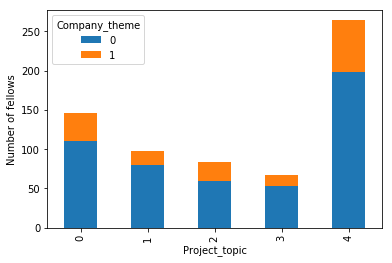

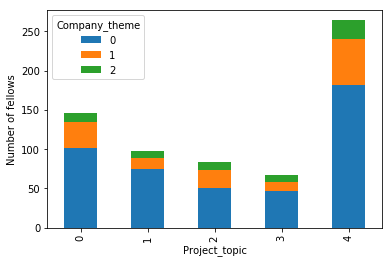

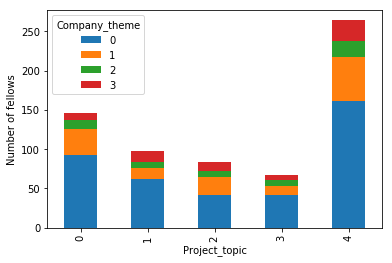

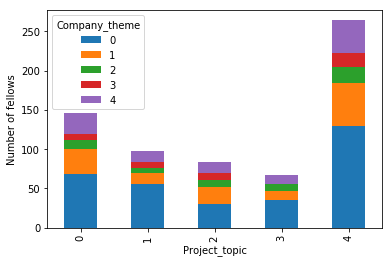

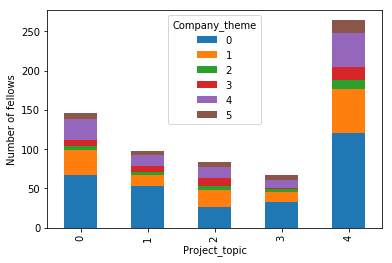

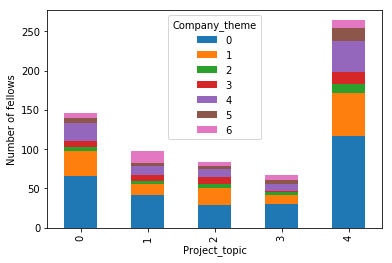

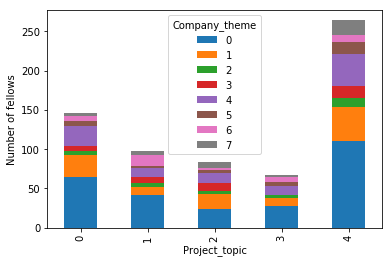

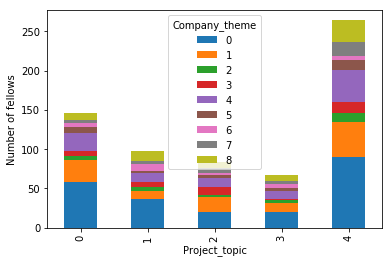

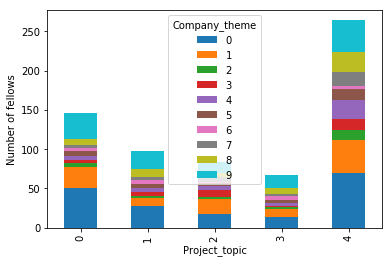

In [18]:
Topics = dom_Proj_topic_df[['n_comp5']].copy()
Topics.columns = ['Project_topic']

for n_comps in n_comp_range:
    name = 'n_comp' + str(n_comps)
    Topics['Company_theme']  = dom_Company_theme_df[name]
    
    ##Print pivot table for actual values to supplement plot
#     Topics['ones'] = np.ones(len(Topics)).astype('int')
#     pivot_table = Topics.pivot_table(index='Project_topic', columns='Company_theme', values='ones', aggfunc='count')
#     print(pivot_table)

    ax = Topics.groupby('Project_topic')['Company_theme'].value_counts().unstack(level=1).plot.bar(stacked=True)
    ax.set_ylabel('Number of fellows')

### 2.3.2b. As can be observed in the above plots, there doesn't appear to be any relationship between company themes (across any number of company_info components) and the five different Project topics.

In the presence of possible relationships (which there are likely none), we might expect the different company themes to be selectively distributed across the Project topics. However, we can see that they are instead quite evenly distributed.

However, it is important to note that a lot of information is lost when we try to force a dominant topic for each Project or Company based on the topic with the largest weight as I did above. It is possible that while Project and Company may be related, this relationship may be different from what was captured by the latent topics formed by NMF.

I think this is unlikely, due to many limitations in the data (e.g. The only information we have for Projects are their names; there was a lot of noise in the company_info column, etc). However, just for the sake of completion I'm going to perform machine learning below to see the extent to which machine learning might be able to relate Project (just the bag of words, to lessen dimensionality reduction) to the different Company themes. Based on my above observations, I really don't think that they will perform well. However, by calculating accuracy we can quantify very quickly across the different Company nmf sizes the general performance to see if there are any relationships that might have been overlooked in the snapshot above. Also, to reduce reliance on any one ML method, I'm going to look at accuracies for linearSVC and logistic regression.

In [19]:
# Using cleaned Project, make Bag of words for X variable
X_temp = merged_df.Project
count = CountVectorizer()
X =  count.fit_transform(X_temp)

logreg_acc = []
linearsvc_acc = []

for n_comps in n_comp_range:
    name = 'n_comp' + str(n_comps)
    y  = dom_Company_theme_df[name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.25,random_state = 123)
    
    ## Perform LogisticRegression
    logreg = LogisticRegression().fit(X_train, y_train)
    logreg_y_pred = logreg.predict(X_test)
    logreg_acc.append(metrics.accuracy_score(y_test, logreg_y_pred))
    
    ## Perform LinearSVC
    linearSVC = LinearSVC().fit(X_train, y_train)
    linearSVC_y_pred = linearSVC.predict(X_test)
    linearsvc_acc.append(metrics.accuracy_score(y_test, linearSVC_y_pred))

print(pd.DataFrame(list(zip(logreg_acc,linearsvc_acc)), columns = ['LogReg accuracy','LinearSVC accuracy'], index = n_comp_range))

    LogReg accuracy  LinearSVC accuracy
2          0.751515            0.715152
3          0.684848            0.606061
4          0.587879            0.521212
5          0.442424            0.381818
6          0.418182            0.315152
7          0.393939            0.296970
8          0.369697            0.315152
9          0.278788            0.200000
10         0.218182            0.212121


### 2.3.2c. The ML results above show that accuracy is higher when relating the Projects bag of words to the dominant themes created for Company when n_comps = 2. However (caution!!!) this is likely due to the inbalanced amounts of fellows separated into the two Company themes at n_comps = 2 (see bar chart below).

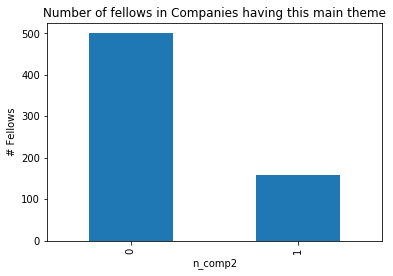

In [20]:
ax = dom_Company_theme_df.groupby('n_comp2').count().n_comp3.plot.bar()
ax.set_title('Number of fellows in Companies having this main theme')
ax.set_ylabel('# Fellows')
plt.show()

# 3. Final remarks

This is the end of my snapshot exploration of Insight fellows' projects and the companies they joined!

As observed, Projects can be separated into topics quite nicely using NMF. Further, based on feature-engineering Company names into company information, I was also able to divide them into topics. However, a lot of company information included location names. 

On the other hand (and as expected for various reasons elaborated on before), I did not find a relationship between Projects and Company. Also, given that I was trying to relate company information to Project names that were usually irrelevant of locations, having location names in the company information made it noisier. It might be better to get company information such as industry information and their products, etc, in future when looking to feature-engineer based on Company names.